In [2]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.cluster import KMeans

# Path to the data folder
data_folder = 'data'

# Function to load all images from the data folder
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if os.path.isfile(img_path) and filename.startswith('tm') and filename.endswith(('.png', '.jpg', '.jpeg')):
            img = Image.open(img_path)
            images.append(np.array(img))
    return images

images = load_images_from_folder(data_folder)

print(f"Number of images loaded: {len(images)}")

Number of images loaded: 10


In [52]:
img_blurred = cv2.GaussianBlur(image_blurred, (5, 5), 0)

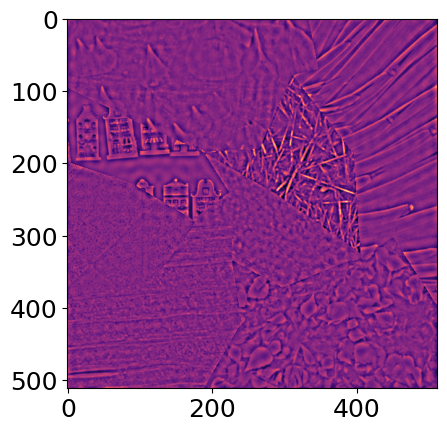

In [60]:
def apply_fourier(img, r_outer=10, r_inner=20):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)

    rows, cols = img.shape
    crow, ccol = rows // 2, cols // 2

    mask = np.ones((rows, cols), np.uint8)

    cv2.circle(mask, (ccol, crow), r_outer, 0, -1)
    cv2.circle(mask, (ccol, crow), r_inner, 1, -1)

    fshift_filtered = fshift * mask

    f_ishift = np.fft.ifftshift(fshift_filtered)
    img_reconstructed = np.fft.ifft2(f_ishift)
    img_reconstructed = np.abs(img_reconstructed)

    return img_reconstructed

img_reconstructed = apply_fourier(image_blurred, r_outer=30, r_inner=0)

plt.imshow(img_reconstructed, cmap='magma')

Initial threshold value: 130
Converged to optimal threshold in 30 iterations with threshold: 110.22245920478905


(-0.5, 511.5, 511.5, -0.5)

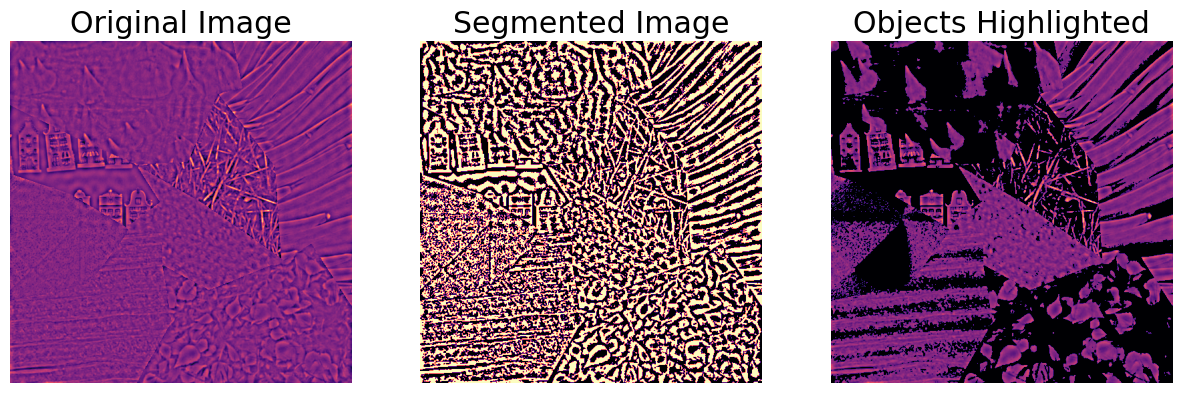

In [61]:
import cv2 
from sklearn.cluster import KMeans

trshld = 130  # Initial threshold value

# Print the initial threshold value
print("Initial threshold value:", trshld)

# Initialize a counter to keep track of iterations
counter = 0

# Start an iterative process to find the optimal threshold
while True:
    # Create a binary mask for the background and object based on the current threshold
    background = img_reconstructed < trshld
    obj = img_reconstructed >= trshld

    # Calculate the mean intensity values for the object and background regions
    meanObjectIntensity = np.mean(img_reconstructed[obj])
    meanBackgroundIntensity = np.mean(img_reconstructed[background])

    # Calculate the new threshold value as the average of object and background intensities
    newTrshld = (meanObjectIntensity + meanBackgroundIntensity) / 2

    # Increment the counter
    counter += 1

    # Check if the absolute difference between the old and new threshold is less than 0.01
    if np.abs(trshld - newTrshld) < 0.01:
        break

    # Update the threshold value with the new value for the next iteration
    trshld = newTrshld

# Print the converged optimal threshold and the number of iterations
print("Converged to optimal threshold in {} iterations with threshold: {}".format(counter, trshld))

# Create a plot to visualize the segmented image and the original image with objects highlighted
plt.figure(figsize=(15, 10))


# Show the first image
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(img_reconstructed, cmap='magma')
plt.axis('off')  # Hide axis

# Show the second image
plt.subplot(1, 3, 2)
plt.title('Segmented Image')
plt.imshow(img_reconstructed > trshld, cmap='magma')
plt.axis('off')  # Hide axis

# Show the third image
plt.subplot(1, 3, 3)
plt.title("Objects Highlighted")
plt.imshow(img_reconstructed * (image_blurred > trshld), cmap='magma')
plt.axis('off')  # Hide axi# Plot the results

Initial threshold value: 130
Converged to optimal threshold in 30 iterations with threshold: 110.22245920478905


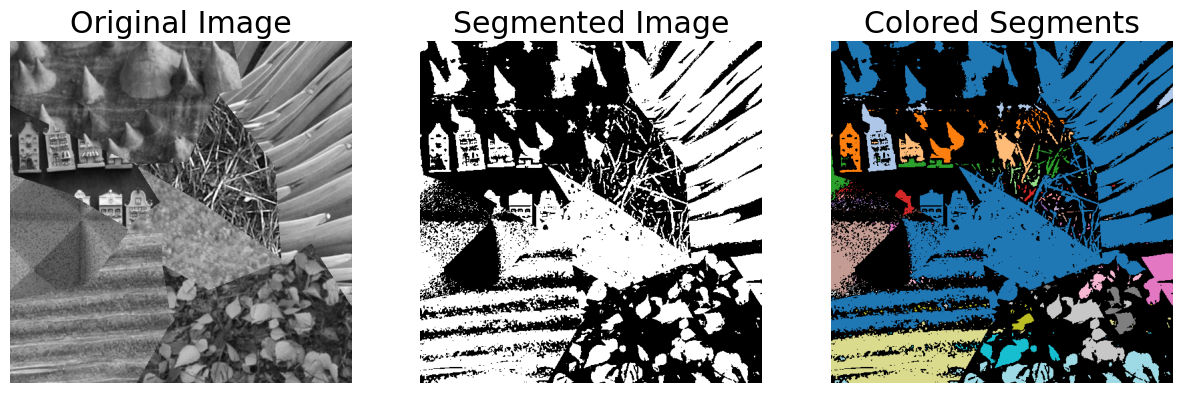

In [62]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label

# Initial threshold value
trshld = 130
print("Initial threshold value:", trshld)

# Initialize a counter to keep track of iterations
counter = 0

# Start an iterative process to find the optimal threshold
while True:
    background = img_reconstructed < trshld
    obj = img_reconstructed >= trshld

    meanObjectIntensity = np.mean(img_reconstructed[obj])
    meanBackgroundIntensity = np.mean(img_reconstructed[background])

    newTrshld = (meanObjectIntensity + meanBackgroundIntensity) / 2
    counter += 1

    if np.abs(trshld - newTrshld) < 0.01:
        break

    trshld = newTrshld

print("Converged to optimal threshold in {} iterations with threshold: {}".format(counter, trshld))

# Segment the image using the computed threshold
segmented_image = image_blurred > trshld

# Label connected regions in the segmented image
labeled_image, num_features = label(segmented_image)

# Generate a color map for the labeled regions
color_map = plt.get_cmap('tab20', num_features)

# Create an RGB image to visualize the segments
colored_segments = np.zeros((*labeled_image.shape, 3), dtype=np.uint8)

# Assign a unique color to each segment
for i in range(1, num_features + 1):
    mask = labeled_image == i
    color = (np.array(color_map(i)[:3]) * 255).astype(int)
    colored_segments[mask] = color

# Plot the original image, the segmented binary image, and the colored segments
plt.figure(figsize=(15, 10))

# Show the original image
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image_blurred, cmap='gray')
plt.axis('off')

# Show the segmented binary image
plt.subplot(1, 3, 2)
plt.title('Segmented Image')
plt.imshow(segmented_image, cmap='gray')
plt.axis('off')

# Show the colored segments
plt.subplot(1, 3, 3)
plt.title("Colored Segments")
plt.imshow(colored_segments)
plt.axis('off')

# Display the plots
plt.show()


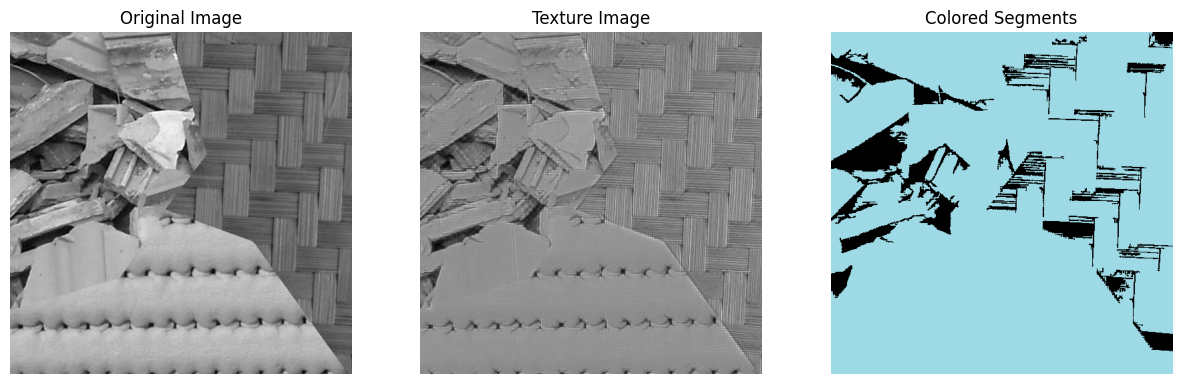

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import morphology

# Load the images
source_image = images[0]

# Define Gabor filter bank
def build_gabor_filters():
    filters = []
    ksize = 31  # Size of the filter
    for theta in np.arange(0, np.pi, np.pi / 4):
        for sigma in (1, 3):
            for lamda in np.arange(np.pi / 4, np.pi, np.pi / 4):
                for gamma in (0.5, 0.75):
                    kern = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)
                    filters.append(kern)
    return filters

# Apply Gabor filters to the image
def apply_gabor_filters(image, filters):
    gabor_features = []
    for kern in filters:
        fimg = cv2.filter2D(image, cv2.CV_8UC3, kern)
        gabor_features.append(fimg)
    return np.array(gabor_features)

# Build and apply filters
filters = build_gabor_filters()
gabor_features = apply_gabor_filters(source_image, filters)

# Sum up the responses of Gabor filters
texture_image = np.sum(gabor_features, axis=0)

# Normalize the texture image
texture_image = cv2.normalize(texture_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# Thresholding to segment the regions
_, segmented_image = cv2.threshold(texture_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Morphological operations to refine the segmentation
segmented_image = morphology.remove_small_objects(segmented_image.astype(bool), min_size=500)
segmented_image = morphology.remove_small_holes(segmented_image, area_threshold=500)

# Label connected components
labeled_image, num_features = morphology.label(segmented_image, return_num=True)

# Generate a color map for the segments
color_map = plt.get_cmap('tab20', num_features)
colored_segments = np.zeros((*labeled_image.shape, 3), dtype=np.uint8)

# Assign a unique color to each segment
for i in range(1, num_features + 1):
    mask = labeled_image == i
    color = (np.array(color_map(i)[:3]) * 255).astype(int)
    colored_segments[mask] = color

# Plot the original image, the texture image, and the colored segments
plt.figure(figsize=(15, 10))

# Show the original image
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(source_image, cmap='gray')
plt.axis('off')

# Show the texture image
plt.subplot(1, 3, 2)
plt.title('Texture Image')
plt.imshow(texture_image, cmap='gray')
plt.axis('off')

# Show the colored segments
plt.subplot(1, 3, 3)
plt.title("Colored Segments")
plt.imshow(colored_segments)
plt.axis('off')

# Display the plots
plt.show()
